In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import datetime
import random
import torch.nn.utils as utils

Get Data

In [2]:
def get_data(path):
    image_extensions = ['.jpg']
    image_names = []
    for filename in os.listdir(path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_names.append(filename)
    return image_names

In [3]:
path = '/Users/ayanfe/Documents/Datasets/animefaces256cleaner'
path1 = '/Users/ayanfe/Documents/Code/Diffusion-Model/model/model.pth'
model_two = '/Users/ayanfe/Documents/Code/Diffusion-Model/model/model_fixed_10000.pth'
model_three = '/Users/ayanfe/Documents/Code/Diffusion-Model/weights/waifu-diffusion-n-cts_1000-30000.pth'
image_names = get_data(path)
print(len(image_names))

92219


In [10]:
timesteps = 1000

# create a fixed beta schedule
def linear():
    beta = np.linspace(0.0001, 0.02, timesteps)
    alpha = 1 - beta
    alpha_bar = np.cumprod(alpha, 0)
    alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
    sqrt_alpha_bar = np.sqrt(alpha_bar)
    one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)
    return sqrt_alpha_bar, one_minus_sqrt_alpha_bar

def cosine(t):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    t = t.astype(float)  # Convert t to float
    t /= timesteps
    start_angle = np.arccos(max_signal_rate)
    end_angle = np.arccos(min_signal_rate)
    diffusion_angles = start_angle + t * (end_angle - start_angle)
    signal_rates = np.cos(diffusion_angles)
    noise_rates = np.sin(diffusion_angles)
    return noise_rates, signal_rates

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_linear_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    sqrt_alpha_bar, one_minus_sqrt_alpha_bar = linear()
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * ((x_0 - 127.5)/127.5) + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

def forward_cosine_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    noise_rates,signal_rates = cosine(t)
    reshaped_noise_rates = np.reshape(noise_rates, (-1, 1, 1, 1))
    reshaped_signal_rates = np.reshape(signal_rates, (-1, 1, 1, 1))
    noisy_image = reshaped_signal_rates  * ((x_0 - 127.5)/127.5) + reshaped_noise_rates * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return torch.randint(0, timesteps,(num,), dtype=torch.int32)

def reshape_img(img,size = (64,64)):
    data = cv2.resize(img,size)
    data = np.transpose(data,(2,0,1))
    return data

Visualize the output image at some timesteps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)


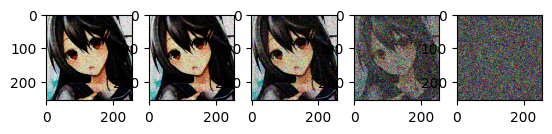

In [14]:
# Let us visualize the output image at a few timestamps
sample_data = plt.imread(path+'/'+image_names[0])

for index, i in enumerate([0,10, 100, 600, 999]):
    noisy_im, noise = forward_cosine_noise(0, np.expand_dims(sample_data, 0), np.array([i,]))
    plt.subplot(1, 5, index+1)
    plt.imshow(np.squeeze(noisy_im,0))
    
plt.show()

In [6]:
def ddim(x_t, pred_noise, t, sigma_t):
    #alpha_t_bar = np.take(alpha_bar, t)
    #alpha_t_minus_one = np.take(alpha, t-1)
    alpha_t_bar = np.take(alpha_bar, t.astype(int))  # Cast t to integer before using np.take
    alpha_t_minus_one = np.take(alpha, (t - 1).astype(int))  # Similarly, cast t-1 to integer

    #alpha_t_bar = torch.from_numpy(alpha_t_bar)
    #alpha_t_minus_one = torch.from_numpy(alpha_t_minus_one)

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one - (sigma_t ** 2)) ** 0.5) * pred_noise
    eps_t = np.random.normal(size=x_t.shape)
    pred = pred+(sigma_t * eps_t)

    return pred

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
def inference(model, device, num_samples=5):
    # Define number of inference loops to run
    inference_timesteps = 10
    
    # Create a range of inference steps that the output should be sampled at
    inference_range = range(0, timesteps, timesteps // inference_timesteps)
    
    x = torch.randn(1, 3, 64, 64).to(device)  # Initialize a random input image on GPU
    img_list = []
    img_list.append(np.squeeze(x.cpu().numpy(), 0))  # Append the initial image
    
    # Iterate over inference_timesteps
    for i in range(inference_timesteps):
        t = np.expand_dims(inference_range[i], 0)
        t = torch.from_numpy(t).type(torch.float32).to(device)
        t = torch.reshape(t, (-1, 1)).type(torch.float32)
        
        pred_noise = model(x, t).detach().to(device)  # Obtain predicted noise
        
        x = ddim(x.cpu().detach().numpy(), pred_noise.cpu().detach().numpy(), t.cpu().detach().numpy(), 0)  # Perform denoising using DDIM
        x = torch.from_numpy(x).type(torch.float32).to(device)  # Transfer denoised image back to GPU
        img_list.append(np.squeeze(x.cpu().detach().numpy(), 0))  # Append the denoised image
    
    # Visualize the final denoised image
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()

In [9]:
start = 1
img_length = len(image_names)
data_length = 30000
data_idx = list(range(0,data_length+32))
random.shuffle(data_idx)


def training_loop(n_epochs, optimizer, model, loss_fn, device, accumulation_steps=1, 
                  epoch_start = 0, batch_size = 64, max_grad_norm=1.0, repeats = 5):
    global start
    with torch.autograd.set_detect_anomaly(True):
        for epoch in range(epoch_start, n_epochs + 1):
            loss_train = 0.0
            accumulated_loss = 0.0
            loss_mae = 0.0
            random.shuffle(data_idx)
            # Use tqdm function for the progress bar
            with tqdm(range(start, (repeats*data_length)//batch_size), desc=f'Epoch {epoch}', unit=' steps') as pbar:
                st = 0
                for x in pbar:
                    # Training loop code
                    sp = st + batch_size
                    if sp > data_length:
                        st = 0
                        sp = st + batch_size
                    img_arr = []
                    for i in range(st,sp):
                        img = plt.imread(path + '/' + image_names[data_idx[i]])
                        img = reshape_img(img)
                        img = np.expand_dims(img, 0)
                        img_arr.append(img)
                    st+= batch_size
                    
                    t = generate_timestamp(0, batch_size)
                    t = torch.reshape(t, (-1, 1)).type(torch.float32)
                    
                    imgs, noise = forward_cosine_noise(None, np.squeeze(np.array(img_arr)), t)
                    
                    imgs = torch.from_numpy(imgs).type(torch.float32).to(device)
                    noise = torch.from_numpy(noise).type(torch.float32).to(device)
                    t = t.to(device)
                    t /= timesteps
                    outputs = model(imgs, t)
                    
                    loss = loss_fn(outputs, noise)
                    
                    # Perform gradient accumulation
                    accumulated_loss += loss / accumulation_steps
                    
                    if x % accumulation_steps == 0:
                        accumulated_loss.backward()

                        # Clip gradients
                        utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                        
                        optimizer.step()
                        optimizer.zero_grad()
                        accumulated_loss = 0.0  # Reset accumulated loss
                    
                    loss_train += loss.item()
                    outputs.detach_()
                    pbar.set_postfix(loss=loss.item())
                
            avg_loss_epoch = loss_train / ((repeats*data_length)//batch_size)
            with open("waifu-diffusion-n-cts_1000-30000-loss.txt", "a") as file:
                file.write(f"Epoch {epoch}: Average Loss: {avg_loss_epoch}\n")
            
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / ((repeats*data_length)//batch_size)))
            inference(model, device)
            #torch.save(model.state_dict(), path1)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_three)
            


In [10]:
from unet import Unet

model = Unet()
#model.load_state_dict(torch.load(model_two))
device = torch.device("mps")
model.to(device)
optimizer = optim.AdamW(model.parameters(),lr=0.0005)  #  <3>
#checkpoint = torch.load(model_three)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#print(epoch)

Total parameters:  27052461


Epoch 1:   0%|                                     | 0/2342 [00:00<?, ? steps/s]/Users/ayanfe/Documents/Code/Diffusion-Model/utils/helper_modules.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  qk = F.softmax(qk)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Epoch 1: 100%|███████████| 2342/2342 [1:17:52<00:00,  2.00s/ steps, loss=0.0858]


2024-03-26 17:21:10.283930 Epoch 1, Training loss 0.12537819696920222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


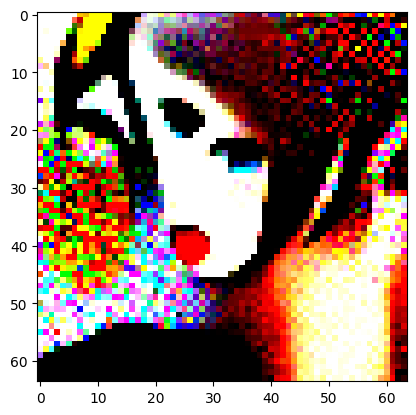

Epoch 2: 100%|███████████| 2342/2342 [1:12:00<00:00,  1.84s/ steps, loss=0.0907]


2024-03-26 18:33:12.896527 Epoch 2, Training loss 0.10223919431139555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


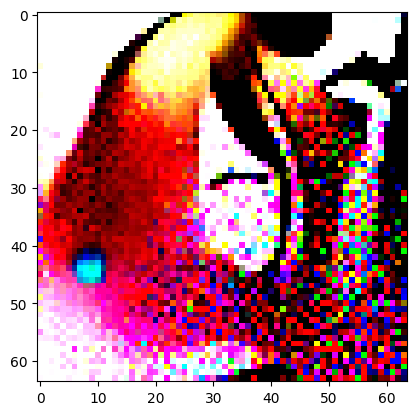

Epoch 3: 100%|███████████| 2342/2342 [1:11:08<00:00,  1.82s/ steps, loss=0.0746]


2024-03-26 19:44:22.876388 Epoch 3, Training loss 0.09910490841144076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


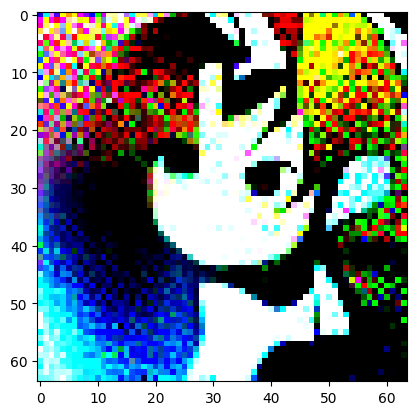

Epoch 4: 100%|███████████| 2342/2342 [1:10:05<00:00,  1.80s/ steps, loss=0.0733]


2024-03-26 20:54:28.976854 Epoch 4, Training loss 0.09706734244545148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


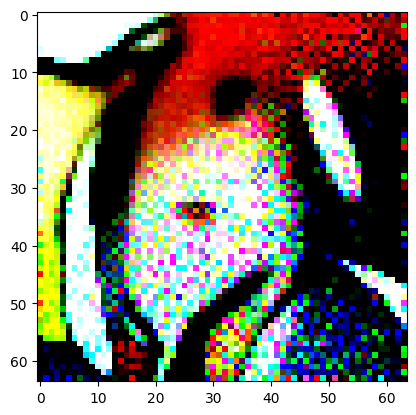

Epoch 5: 100%|████████████| 2342/2342 [1:09:32<00:00,  1.78s/ steps, loss=0.131]


2024-03-26 22:04:02.178059 Epoch 5, Training loss 0.09540571109560683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


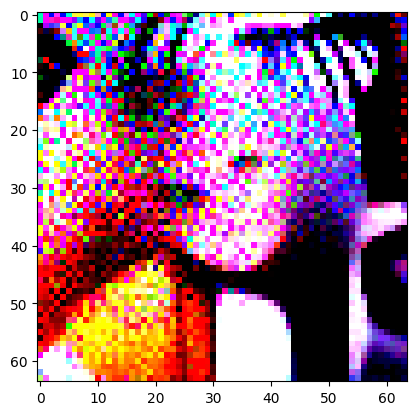

Epoch 6: 100%|██████████████| 2342/2342 [1:10:45<00:00,  1.81s/ steps, loss=0.1]


2024-03-26 23:14:48.660567 Epoch 6, Training loss 0.09441593247241206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


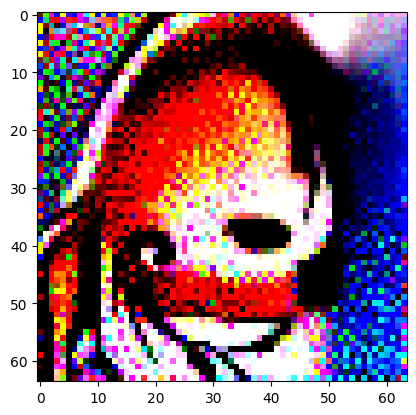

Epoch 7: 100%|███████████| 2342/2342 [1:11:26<00:00,  1.83s/ steps, loss=0.0794]


2024-03-27 00:26:15.952588 Epoch 7, Training loss 0.09368995382008113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


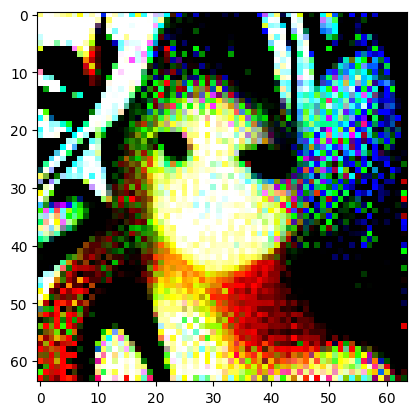

Epoch 8: 100%|███████████| 2342/2342 [1:10:03<00:00,  1.79s/ steps, loss=0.0899]


2024-03-27 01:36:20.414678 Epoch 8, Training loss 0.0933922641026989


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


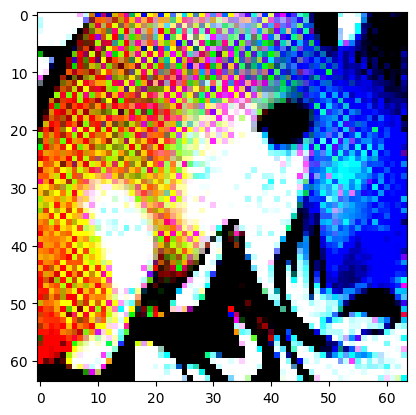

Epoch 9: 100%|████████████| 2342/2342 [1:10:14<00:00,  1.80s/ steps, loss=0.111]


2024-03-27 02:46:35.903052 Epoch 9, Training loss 0.09279156637958771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


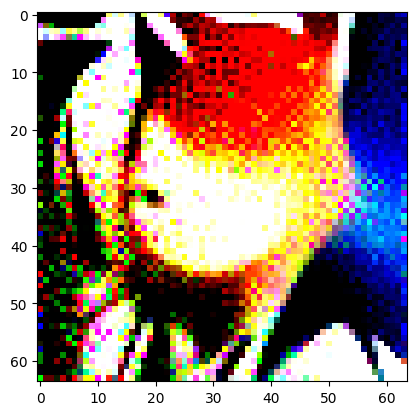

Epoch 10: 100%|███████████| 2342/2342 [1:10:04<00:00,  1.80s/ steps, loss=0.095]


2024-03-27 03:56:41.433312 Epoch 10, Training loss 0.09319119238562174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


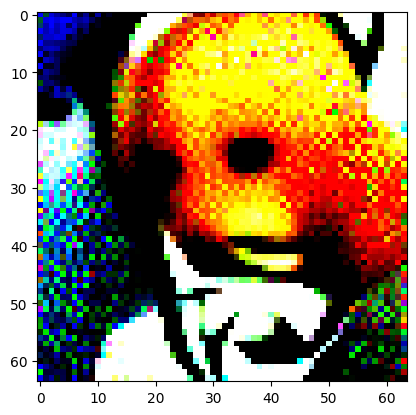

Epoch 11: 100%|██████████| 2342/2342 [1:10:12<00:00,  1.80s/ steps, loss=0.0876]


2024-03-27 05:06:55.476645 Epoch 11, Training loss 0.09253857601187547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


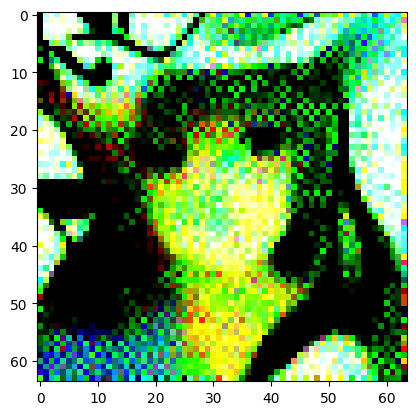

Epoch 12: 100%|███████████| 2342/2342 [1:10:13<00:00,  1.80s/ steps, loss=0.104]


2024-03-27 06:17:09.750986 Epoch 12, Training loss 0.0921483902873593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


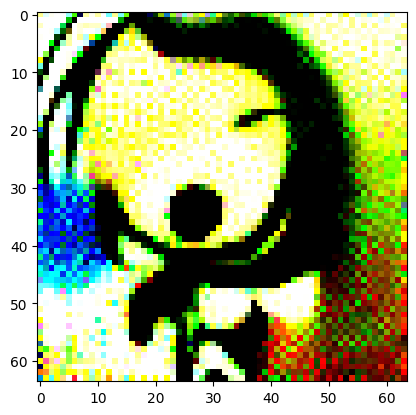

Epoch 13: 100%|███████████| 2342/2342 [1:10:05<00:00,  1.80s/ steps, loss=0.085]


2024-03-27 07:27:15.975175 Epoch 13, Training loss 0.09179168478977309


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


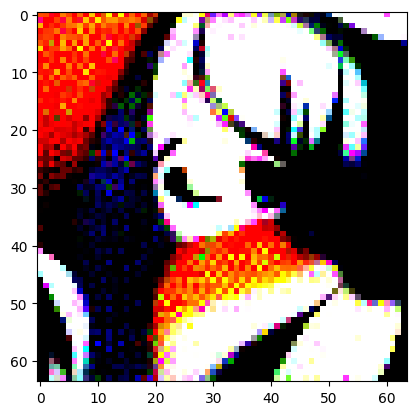

Epoch 14:   6%|▋           | 135/2342 [04:04<1:06:38,  1.81s/ steps, loss=0.101]


KeyboardInterrupt: 

In [11]:
print("Total parameters: ",count_parameters(model))
loss_fn = nn.MSELoss()  #  <4>

training_loop(  # <5>
    n_epochs = 1000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    device = device,
    epoch_start = 1
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


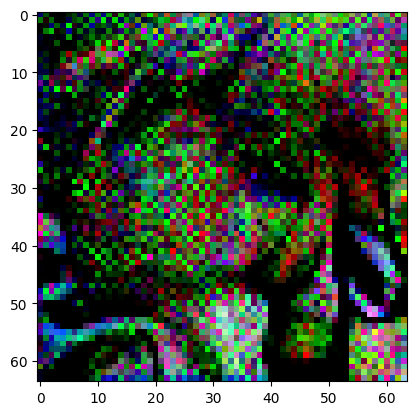

In [21]:
inference(model, device)

In [ ]:
x_0 = torch.rand(10,3,128,128).numpy()
t = torch.range(1,10)
print(t.shape)
sg, ns = forward_noise(0,x_0,t)
print(sg.shape)
print(ns.shape)